In [105]:
import madmom
madmom.__version__

'0.17.dev0'

In [106]:
import librosa
librosa.__version__

'0.9.0'

In [107]:
# Preprocessing Data
import xmltodict
from urllib.parse import unquote

with open('beats.xml') as f:
    doc = xmltodict.parse(f.read())

data = doc['DJ_PLAYLISTS']['COLLECTION']['TRACK']

data = data[-10:]
churry = []

k = 0

for i in data:
    churry.append({'path': 'Music files/'+unquote(i['@Location']).split('/')[-1],
                  'beats': [],
                  'downbeats': []
                  })

    beat = 60/float(i['@AverageBpm'])

    if isinstance(i['TEMPO'], list):
        for j in range(len(i['TEMPO'])):
            t = float(i['TEMPO'][j]['@Inizio'])
            d = int(i['TEMPO'][j]['@Battito'])
            if j < len(i['TEMPO'])-1:
                u = float(i['TEMPO'][j+1]['@Inizio'])
            else:
                u = float(i['@TotalTime'])
            while t < u:
                if u - t > beat:
                    churry[k]['beats'].append(t)
                    churry[k]['downbeats'].append(d)
                t += beat
                d += 1
                if d == 5:
                    d = 1

    else:
        t = float(i['TEMPO']['@Inizio'])
        d = int(i['TEMPO']['@Battito'])
        u = float(i['@TotalTime'])
        while t < u:
            churry[k]['beats'].append(t)
            churry[k]['downbeats'].append(d)
            t += beat
            d += 1
            if d == 5:
                d = 1
    k += 1

In [108]:
#loading mp3
import numpy as np
from pydub import AudioSegment


def load_pydub_audio(path):
  # Load the audio using smart open. It supports streaming large audio files at remote
  # storages such as AWS S3.
    file_obj = open(path, 'rb')
    pydub_audio = AudioSegment.from_file(file_obj)
    return pydub_audio


def load_audio(path, sample_rate=44100, num_channels=1, sample_width=2, normalize=False, dtype='float32'):
    pydub_audio = load_pydub_audio(path)
    # Resample if `sample_rate` is given.
    if sample_rate:
        pydub_audio = pydub_audio.set_frame_rate(sample_rate)
    else:
        sample_rate = pydub_audio.frame_rate
    # Set the number of channel (default: mono)
    pydub_audio = pydub_audio.set_channels(num_channels)
    pydub_audio = pydub_audio.set_sample_width(sample_width)
    # Normalize audio gain (dB) if `normalize` is `True`.
    if normalize:
        # headroom is how close to the maximum volume to boost the signal up to (specified in dB)
        pydub_audio = pydub_audio.normalize(headroom=0.1)
    # Efficient conversion from pydub.AudioSegment to numpy array.
    array_buf = np.frombuffer(pydub_audio.raw_data, dtype=pydub_audio.array_type)
    array_buf = array_buf.reshape(pydub_audio.channels, -1, order='F')
    array_buf = array_buf.squeeze()
    array = array_buf.astype(dtype)
    assert array_buf.dtype == np.int16
    array /= np.iinfo(array_buf.dtype).max
    return array, sample_rate

In [109]:
from madmom.processors import ParallelProcessor, Processor, SequentialProcessor
from madmom.audio.signal import SignalProcessor, FramedSignalProcessor
from madmom.audio.stft import ShortTimeFourierTransformProcessor
from madmom.audio.spectrogram import (
    FilteredSpectrogramProcessor, LogarithmicSpectrogramProcessor,
    SpectrogramDifferenceProcessor)

In [110]:
# MADMOM METHOD

sig = SignalProcessor(num_channels=1, sample_rate=44100, dtype='float32')(churry[0]['path'])

In [111]:
sig.shape

(20355694,)

In [112]:
frames = FramedSignalProcessor(frame_size=4096, fps=100)(sig)

In [113]:
frames.shape

(46159, 4096)

In [114]:
stft = ShortTimeFourierTransformProcessor()(frames)
filt = FilteredSpectrogramProcessor(num_bands=12, fmin=30, fmax=17000, norm_filters=True)(stft)
spec = LogarithmicSpectrogramProcessor(mul=1, add=1)(filt)
diff = SpectrogramDifferenceProcessor(diff_ratio = 0.5, positive_diffs = True, stack_diffs=np.hstack)(spec)

In [115]:
stft.shape, filt.shape, spec.shape, diff.shape

((46159, 2048), (46159, 91), (46159, 91), (46159, 182))

In [116]:
beats = np.around(np.array(churry[0]['beats']),2)

downbeats = np.array(churry[0]['downbeats'])
downbeats_filter = downbeats == 1
down_downbeats = beats[downbeats_filter]
else_beats = beats[np.invert(downbeats_filter)]

In [121]:
down_downbeats

array([4.0000e-02, 1.9600e+00, 3.8800e+00, 5.8000e+00, 7.7200e+00,
       9.6400e+00, 1.1560e+01, 1.3480e+01, 1.5400e+01, 1.7330e+01,
       1.9250e+01, 2.1170e+01, 2.3090e+01, 2.5010e+01, 2.6930e+01,
       2.8850e+01, 3.0770e+01, 3.2690e+01, 3.4600e+01, 3.6520e+01,
       3.8440e+01, 4.0360e+01, 4.2280e+01, 4.4200e+01, 4.6120e+01,
       4.8040e+01, 4.9960e+01, 5.1880e+01, 5.3800e+01, 5.5720e+01,
       5.7640e+01, 5.9560e+01, 6.1480e+01, 6.3400e+01, 6.5320e+01,
       6.7240e+01, 6.9160e+01, 7.1080e+01, 7.3000e+01, 7.4920e+01,
       7.6840e+01, 7.8760e+01, 8.0680e+01, 8.2600e+01, 8.4520e+01,
       8.6440e+01, 8.8360e+01, 9.0290e+01, 9.2210e+01, 9.4130e+01,
       9.6050e+01, 9.7970e+01, 9.9890e+01, 1.0181e+02, 1.0373e+02,
       1.0565e+02, 1.0757e+02, 1.0949e+02, 1.1141e+02, 1.1333e+02,
       1.1525e+02, 1.1717e+02, 1.1909e+02, 1.2101e+02, 1.2293e+02,
       1.2485e+02, 1.2677e+02, 1.2869e+02, 1.3061e+02, 1.3253e+02,
       1.3445e+02, 1.3637e+02, 1.3829e+02, 1.4021e+02, 1.4213e

In [117]:
spec.T.shape == diff.T[:21].shape

False

(91, 46159)
(364, 46159)


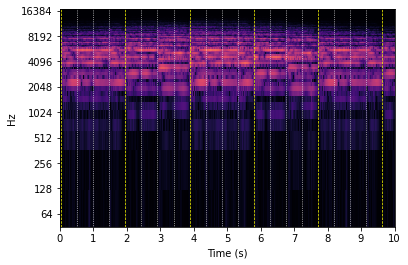

In [122]:
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches

answer = []
xlim=(0,10)

what = np.concatenate((spec.T, diff.T, spec.T))

print(spec.T.shape)

# fig,ax = plt.subplots(figsize=[10,3])
# # plt.figure(figsize=[4.3, 4.8], frameon=False)
# plt.axis('off')
# librosa.display.specshow(what, sr=44100, hop_length=441, y_axis='mel', x_axis='s')
# ax.set(ylim=(30,17000))
# ax.vlines(down_downbeats, 30, 17000, colors='yellow', ls='--', linewidth=0.7, label='1')
# ax.vlines(else_beats, 30, 17000, colors='white', ls='dotted', linewidth=0.7, label='1')

spec_arr = spec.T[:,:1000]
print(what.shape)

fig,ax = plt.subplots()
librosa.display.specshow(spec.T, sr=44100, hop_length=441, y_axis='log', x_axis='s')
ax.set(xlim = (0, 10), ylim=(30,17000))
ax.vlines(down_downbeats, 30, 17000, colors='yellow', ls='--', linewidth=0.7, label='1')
ax.vlines(else_beats, 30, 17000, colors='white', ls='dotted', linewidth=0.7, label='1')

# fig.savefig('spec_data/1.png')

for i in range(0, len(spec)):
    if (beats == i/100).any():
        answer.append(1)
    else:
        answer.append(0)
#     if i/100 <xlim[1] and i/100 > xlim[0]:
#         if (beats == i/100).any():
#             ax.text(i/100,19300,'1', size='x-small')
#         else:
#             ax.text(i/100,17500,'0', size='xx-small')

answer_arr = np.array(answer, dtype=np.float32)
plt.show()

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [80]:
spec.T[:,:100].shape

(21, 100)

In [81]:
feed = np.array(spec.T[:,:1000])
feed.shape

(21, 1000)

/home/youngjae/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


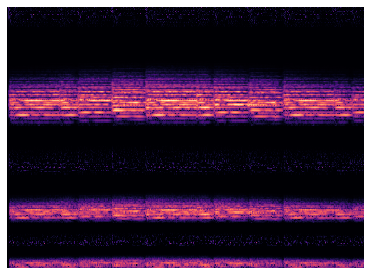

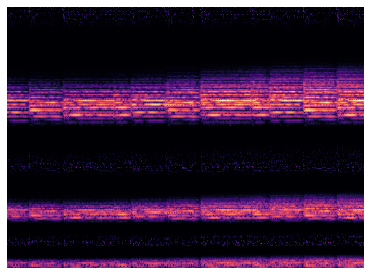

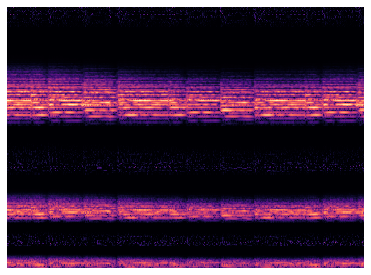

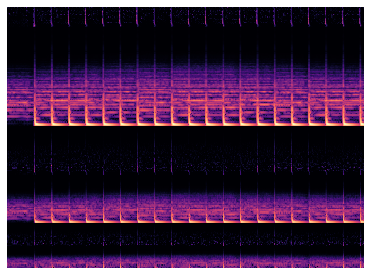

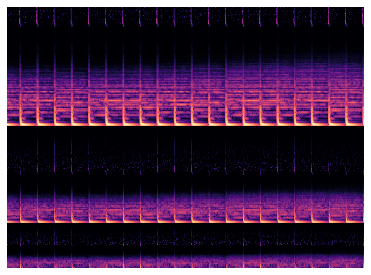

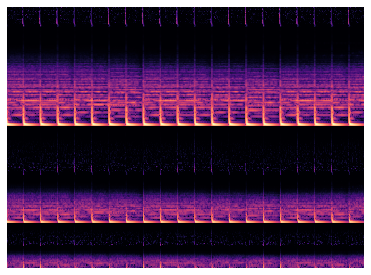

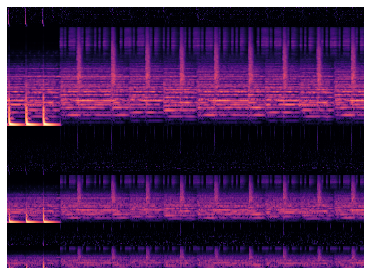

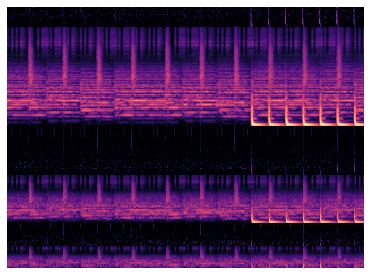

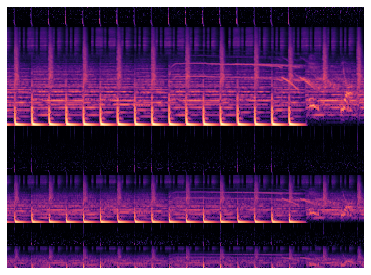

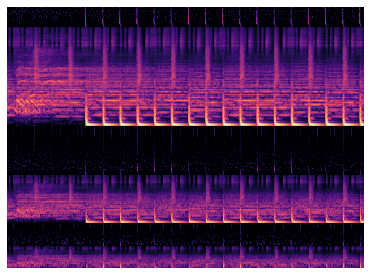

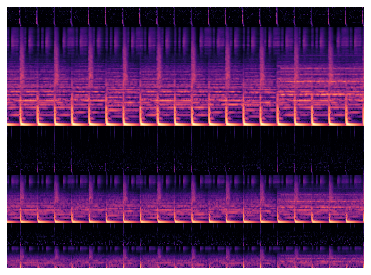

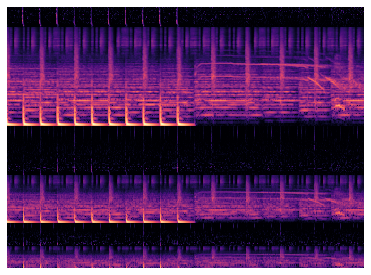

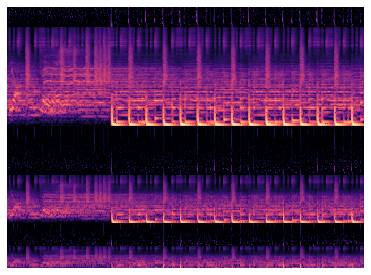

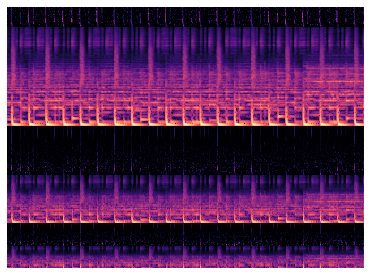

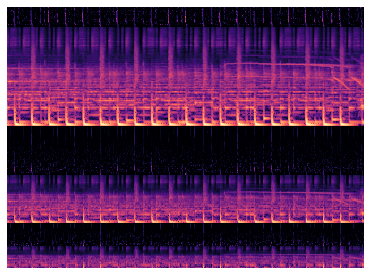

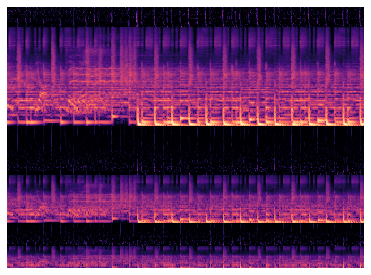

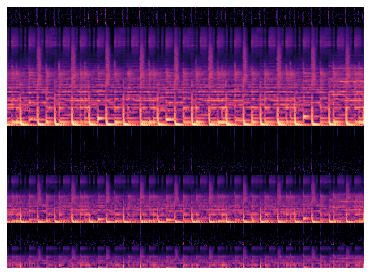

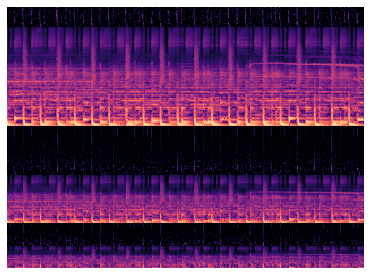

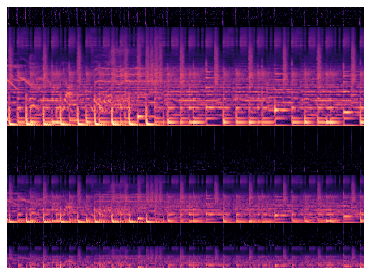

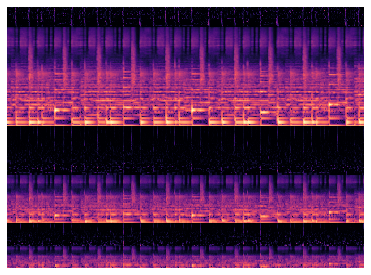

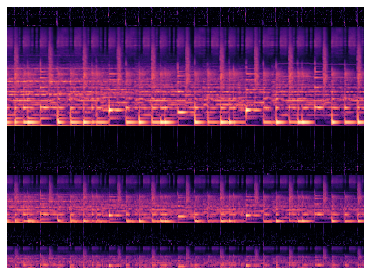

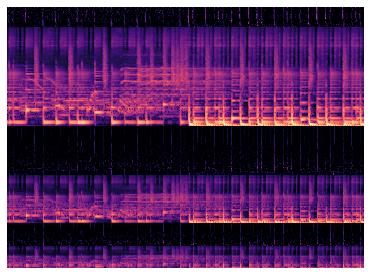

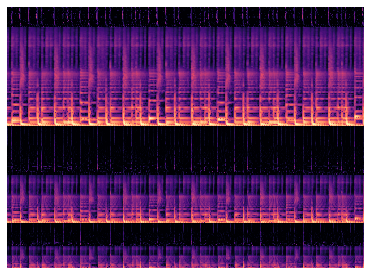

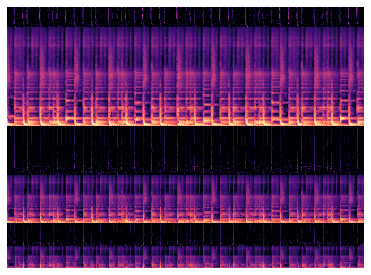

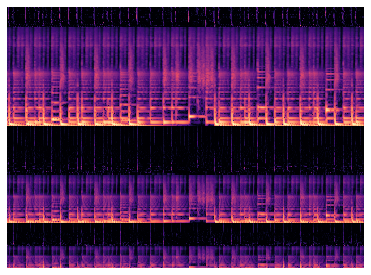

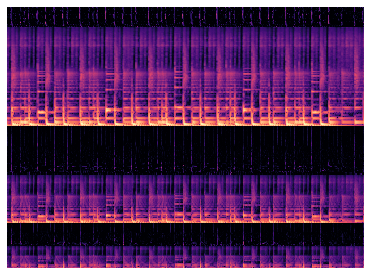

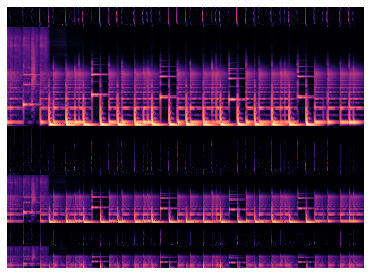

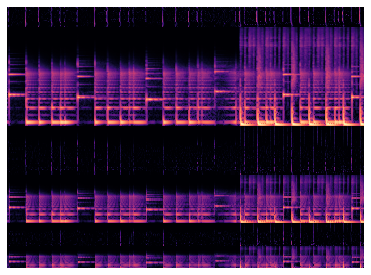

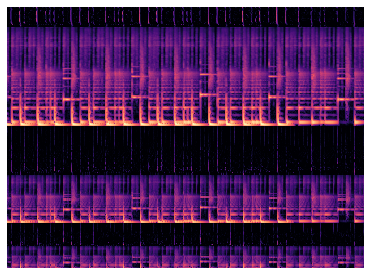

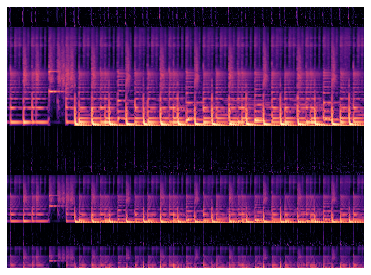

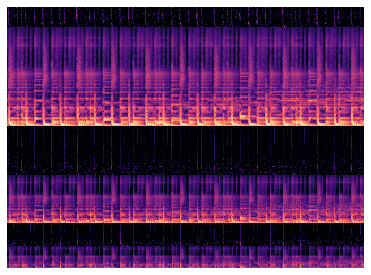

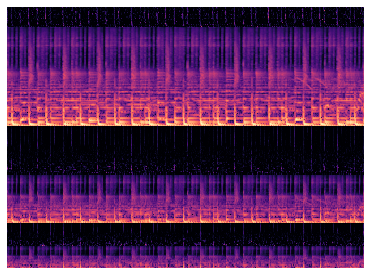

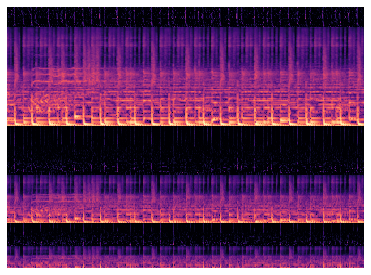

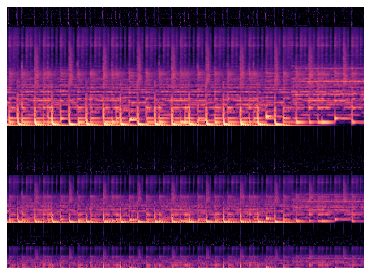

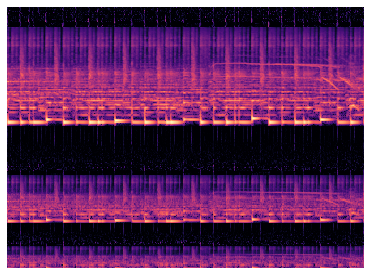

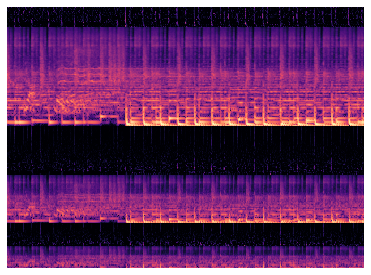

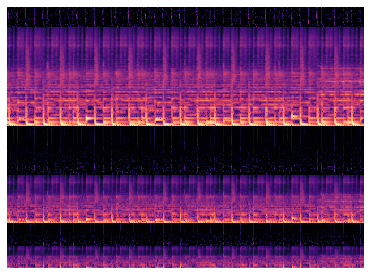

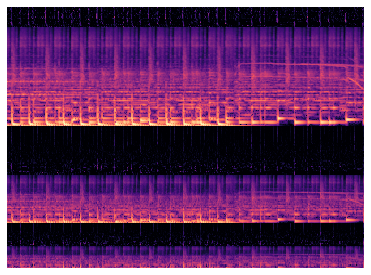

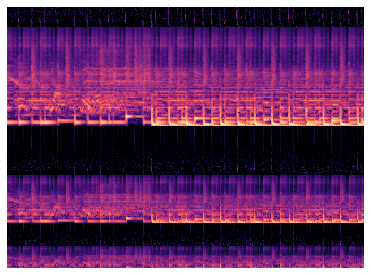

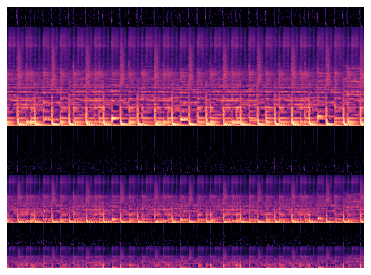

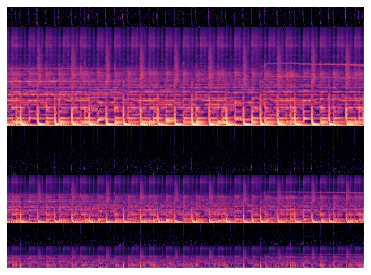

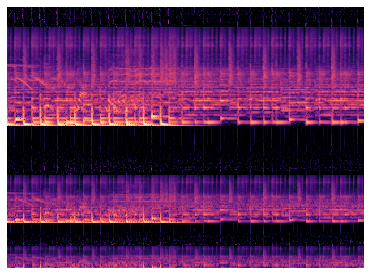

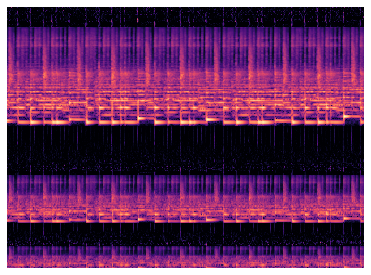

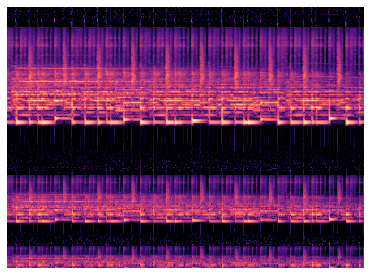

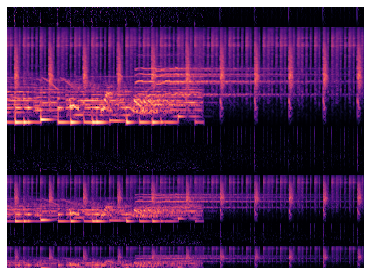

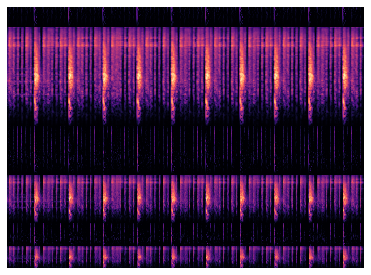

In [82]:
frame_sizes = [1024, 2048, 4096]
num_bands = [3, 6, 12]

feed = []

for i in range(len(spec)//1000):
    array = []
    
    for frame_size, num_band in zip(frame_sizes, num_bands):
        
        frames = FramedSignalProcessor(frame_size=frame_size, fps=100)(sig)
        stft = ShortTimeFourierTransformProcessor()(frames)
        filt = FilteredSpectrogramProcessor(num_bands = num_band, fmin=30, fmax=17000, norm_filters=True)(stft)
        spec = LogarithmicSpectrogramProcessor(mul=1, add=1)(filt)
        diff = SpectrogramDifferenceProcessor(diff_ratio = 0.5, positive_diffs = True, stack_diffs=np.hstack)(spec)
        
        spec_reshaped = spec.T[:, 1000*i : 1000*i + 1000]
        diff_reshaped = diff.T[:, 1000*i : 1000*i + 1000]
        
        if len(array) == 0:
            array = diff_reshaped
        
        else:
            array = np.concatenate((array, diff_reshaped))
        
    fig,ax = plt.subplots(figsize = [6.4, 4.8])
    plt.axis('off')
    librosa.display.specshow(array, sr=44100, hop_length=441, y_axis='linear', x_axis='s')
    ax.set(ylim=(30,17000))
    
    np.save('spec_data/{}'.format(i), array)
        
        
    
    

In [87]:
load = np.load('spec_data/10.npy')
load.shape

(314, 1000)

In [88]:
load[0:21].shape, load[21:42].shape

((21, 1000), (21, 1000))

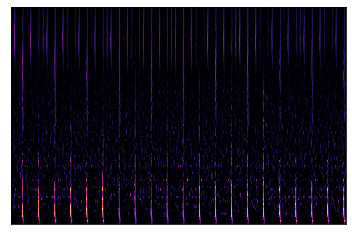

In [104]:
librosa.display.specshow(load[223:314])